## Homework 5: Calibration error

### Introduction
In this lab, we're going to be investigating ways to assess the calibration of a prediction function.  So that we can use as much data as we want, we're going to be using an artificial data generator.  At the beginning of this assignment we fit a logistic regression model $f$, and almost the entire assignment is about investigating the calibration of $f$.

### Setup

Below we set up the data generator and fit our model $f$.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import numpy as np
from typing import List, Tuple
from math import sqrt
from random import choices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from data import ClassificationDataGenerator
from scipy.stats import beta
from itertools import product


In [4]:
# NOTE: Later in the assignment, when we start drawing lots of large samples, you
# will start seeing "Shuffling..." printed out.  This happens every time we go
# through all full_n draws from the distibution.  At that point, you may want to
# rerun this data generation, increasing full_n by a factor of 10 or so.
seed = 41
cdg = ClassificationDataGenerator(
    n_features=20, n_informative=2, n_redundant=2, random_state=seed, full_n=1000000
)
train_size = 1000
val_size = 200
X_train, y_train = cdg.get_sample(train_size)
X_val, y_val = cdg.get_sample(val_size)
lr = LogisticRegression(penalty="l2")
lr_grid = {"C": [10 ** x for x in range(-3, 3)]}
clf = GridSearchCV(estimator=lr, param_grid=lr_grid, scoring="roc_auc")
clf.fit(X_train, y_train)
f = clf.best_estimator_


### Reliability Diagrams
Now we'll generate some reliability diagrams for $f$.  As discussed in lecture, this requires creating a binned version of $f$.  We'll start by creating a class to do the binning.
#### Problem 1. Complete the Binner class to compute bins using the quantile method.  Then run the code below to [lightly] test the class.

In [39]:
class Binner:
    def __init__(self, n_bins: int = 10):
        self.n_bins = n_bins
        self.bins = None

    def fit(self, x: np.ndarray):
        """Figures out bin boundaries using quantiles of x

        Args:
            x (np.ndarray): 1-dimensional numpy array of numbers in [0,1].
        """
        #TODO

    def get_bins(self, x: np.ndarray) -> np.ndarray:
        """Returns bin index {0,...,n_bin-1} for each entry of x

        Args:
            x (np.ndarray): 1-dimensional numpy array of numbers in [0,1]

        Returns:
            np.ndarray: 1-dimensional numpy array with bin assignments in {0,...,n_bin-1}
        """
        if self.bins is None:
            self.fit(x)

        #TODO (hint: np.digitize could be useful?)


In [ ]:
# When all the numbers in x are distinct (as they are here), the number of entries in each
# bin should be within 1 of each other.
n_bins = 5
binner = Binner(n_bins=n_bins)
x = np.array([0.1, 0.2, 0.3, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.9, 0.99, 0.999])
print(binner.get_bins(x))


To plot a a reliability diagram for a prediction function, we bin the predictions for a particular dataset, and then we find the average prediction and label value in each bin.  It turns out, we have to do essentially the same things to make a histogram calibrator (techincally we don't need the average prediction of each bin). Thus in the next problem we're going to implement a class that does histogram calibration.  We'll also have it compute a few extra things that we don't strictly need for calibration or reliability diagrams, as they'll be useful later for computing calibration error. 

#### Problem 2:  Complete the HistogramCalibrator class below. 

In [17]:
class HistogramCalibrator:
    def __init__(
        self, binner: Binner, x_agg_fn=np.mean, y_agg_fn=np.mean, refit_binner=True
    ):
        """Fits a calibration function to probability predictions and labels

        Args:
            binner (Binner): binner used to partition predicted probabilities
            x_agg_fn (function of a numpy array, optional): How to summarize x values in a bin. Defaults to np.mean.
            y_agg_fn (function of a numpy array, optional): How to get y value to predict for a bin from observed y values in the bin. Defaults to np.mean.
            refit_binner (bool, optional): If False, assume binner has already beenn fit. Defaults to True.
        """

        self.binner = binner
        self.x_agg_fn = x_agg_fn
        self.y_agg_fn = y_agg_fn
        self.refit_binner = refit_binner
        self.y_agg = None
        self.x_agg_by_bin = []
        self.y_agg_by_bin = []
        self.bin_cnts = []

    def fit(self, x: np.ndarray, y: np.ndarray):
        """Fits histogram calibration

        This function must set the following variables:

        self.x_agg_by_bin: gives the aggregate x value for each bin (has length binner.n_bins)
        self.y_agg_by_bin: gives the aggregate y value for each bin (has length binner.n_bins)
        self.bin_cnts: gives the count of x values in each bin (has length binner.n_bins)
        self.y_agg: the aggregate y value (with default aggregation function, this is just np.mean(y))

        It may happen that there are no x values in certain bins.  In this case, store a
        placeholder (e.g. 0.0) in the relevant slot of the agg_by_bin arrays.

        Although we don't do this in this homework, we could allow for
        generating confidence intervals for our bin probability estimates by letting
        y_agg_fn return an arbitrary object.

        Args:
            x (np.ndarray): Predicted probabilities
            y (np.ndarray): Ground truth 0/1 labels corresponding to x
        """
        if self.refit_binner:
            self.binner.fit(x)

        #TODO

    def predict(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Given uncalibrated predictions x returns binned x and calibrated predictions

        Args:
            x (np.ndarray): the uncalibrated probability predictions

        Returns:
            (x_pred: np.ndarray, y_pred: np.ndarray): each the same size as x, with
                x_pred containing the aggregated value of x's for each bin
                and y_pred containing the aggregated value of y's for each bin
        """

        #TODO


#### Problem 3:  Use the HistogramCalibrator to complete the code below to plot a reliability diagram for $f$ using 15 bins.

In [7]:
def plot_reliability_diagram(
    ax, pred_probs, actual_probs, title="Reliability diagram", error_bars=None
):
    if error_bars is not None:
        ax.errorbar(pred_probs, actual_probs, yerr=error_bars, capsize=3, marker="o")
    else:
        ax.plot(pred_probs, actual_probs, marker="o")

    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax.set_ylabel("Estimated probability")
    ax.set_xlabel("Predicted Probability")
    ax.set_title(title)
    ax.legend()
    return ax


def plot_data_histogram(ax, preds):
    ax.hist(preds, histtype="step", lw=2)
    ax.set_ylabel("Count")
    ax.set_xlabel("Predicted probability")
    return ax


In [ ]:
n = 1000
n_bins = 15
X, y = cdg.get_sample(n=n)
preds = f.predict_proba(X)[:, 1]

#TODO
binned_predictions = #TODO
binned_label_proportions = #TODO

title = f"n={n}, binning with {n_bins} bins"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_reliability_diagram(ax1, binned_predictions, binned_label_proportions, title=title)
plot_data_histogram(ax2, preds)


#### Problem 4: Complete the code to plot reliability diagrams (no need for the histogram) for the 5 different bin counts specified below.  Then answer the question following the code.

In [ ]:
n = 1000
X, y = cdg.get_sample(n=n)
preds = f.predict_proba(X)[:, 1]
n_bins_arr = [5, 10, 20, 50, 100]
ncol = len(n_bins_arr)
fig, axes = plt.subplots(1, ncol, figsize=(24, 10))
for col in range(ncol):
    ax = axes[col]
    n_bins = n_bins_arr[col]

    #TODO
    
    title = f"n={n}, binning with {n_bins} bins"
    plot_reliability_diagram(ax, binned_predictions, binned_label_proportions, title=title)


For 100 bins, the points plotted only occur at multiples of 0.1 -- why is that?  What do these plots tell you about the calibration of the function $f$? (e.g. when is it over/underpredicting?)

### Histogram calibration
Let's now use our HistogramCalibrator to make f_calib, a histogram-calibrated version of $f$, and let's create a reliability diagram for f_calib. Note that f_calib will have only a fixed number of distinct outputs, equal to the number of bins used in the calibration.  To make a reliability diagram for such a function, it's easiest to just assign each distinct predicted value to its own bin.  We provide code for a Binner that does just that below.

#### Problem 5: Use new data to calibrate $f$ using histogram binning with 15 bins.  Then use yet another new set of data to generate a reliability diagram, using one bin for each distinct probability output of f_calib. Comparing to the reliability diagram with 15 bins that we did for $f$, do you think the histogram calibrated version of $f$ has better calibration? Why or why not?

In [10]:
class BinnerAllValues(Binner):
    def __init__(self):
        self.bins = None

    def fit(self, x=None):
        vals = np.unique(x)  # unique returns sorted values
        bin_num = 0
        self.bin_lookup = {}
        for val in vals:
            self.bin_lookup[val] = bin_num
            bin_num += 1
        self.n_bins = bin_num

    def get_bins(self, x: np.ndarray):
        if self.bins is None:
            self.fit(x)

        x_bins = np.array([self.bin_lookup[val] for val in x])
        return x_bins


In [ ]:
# Fit the histogram calibrator using 15 bins
n = 5000
n_bins = 15
X, y = cdg.get_sample(n=n)
preds = f.predict_proba(X)[:, 1]
# TODO

# Use new data to generate a reliability diagrams for the histogram-calibrated f
n = 5000
X, y = cdg.get_sample(n=n)
preds = f.predict_proba(X)[:, 1]
preds_calib = # TODO (should be the histogram-calibrated predictions on X)
#TODO

title = f"n={n}, binning with {n_bins} bins"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_reliability_diagram(ax1, x_bin_means, y_calib, title=title)
plot_data_histogram(ax2, preds_calib)


### Estimating calibration error.
Sometimes we want a numeric assessment of calibration, such as when we want to compare the performance of a large number of models. As our point of departure, let's recall Figure 2a from [Verified Uncertainty Calibration](https://arxiv.org/abs/1909.10155) by Kumar et al (2019), which we also discussed in lecture:

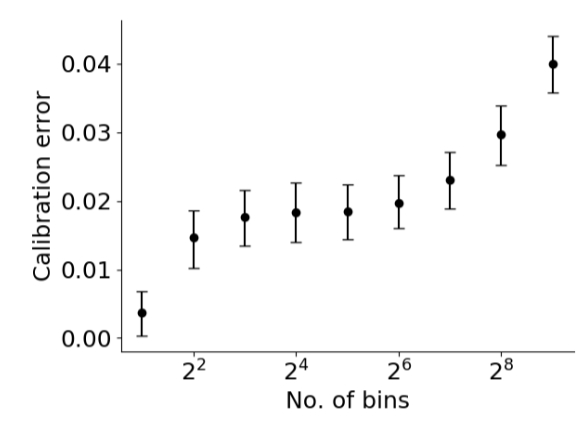

The graph shows estimated calibration errors for varying numbers of bins, with a clear and consistent trend upwards. The paper says "as we increase the number of bins on ImageNet, the measured calibration error is higher and this is statistically significant."  Presumably the "statistical significance" is referring to the error bars, which they computed using the bootstrap.  They go on to say "For example, if we use 15 bins as in ..., we would think the calibration error is around 0.02 when in reality the calibration error is at least twice as high."  You may be questioning how true this statement is by the end of the lab.

Their general point is that binning underestimates calibration error (their Proposition 3.3), and they present this image as an illustration of how strong this effect is -- as we increase the number of bins, we reveal more and more calibration error, and who knows where it will end? They conclude their figure caption by saying "This suggests that binning cannot be reliably used to measure the true calibration error."  What we'll see in this part of the lab is that, while underestimating calibration error with binning is a real effect, it probably is not the principle factor at play when the number of bins grows large.  

To get you thinking, notice that the confidence intervals are not getting larger as we increase the number of bins.  With that being the case, why not just keep using a larger number of bins, since that should reduce the underestimate without any downside in the form of increased variance?  Are we missing something? Hint: The error bars only capure the variance, not the bias.

In the problems below, we'll use our own data generator and prediction function $f$ to generate a plot that's very similar to Figure 2a from Kumar et al.  We'll then analyze it in various ways to try to gain some insight into the claims of the paper.



Below you'll write an estimator for calibration error (CE) and run the code provided to produce a figure similar to the one from Kumar et al.  You'll only implement the "plug-in" estimator of CE, as discussed in lecture.  The other methods referenced in the function signature below are "bias-corrected" estimators, and you can find out more about them in [this paper](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.1924) by Ferro and Fricker (2012).

#### Problem 6: Complete the function below to compute an estimated calibration error using binning, and run the code following it. 

In [12]:
def get_calibration_error_estimate(
    binner: Binner,
    predictions: np.ndarray,
    labels: np.ndarray,
    method: str = ["plugin", "ferro", "brocker"][0],
):
    #TODO


While the paper used the bootstrap to estimate the variance of their CE estimates, we'll take advantage of the fact that we have a data generator and simply generate 20 independent CE estimates, which we can use to get a better estimate of variance.

<AxesSubplot:xlabel='num_bins', ylabel='CE'>

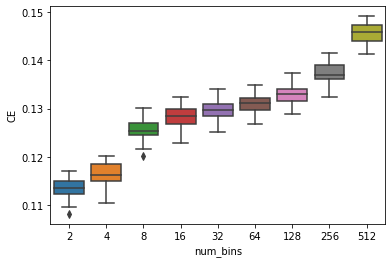

In [19]:
# Increase the number of bins and visualize the validation error, repeat for multiple test set sizes
num_bins = [2, 4, 8, 16, 32, 64, 128, 256, 512]

binners = {}
## Precompute binners on separate data
X, _ = cdg.get_sample(5000)
preds = f.predict_proba(X)[:, 1]
for b in num_bins:
    binner = Binner(n_bins=b)
    binner.fit(preds)
    binners[b] = binner

# Presample datasets and make predictions
prediction_repeats = []
label_repeats = []
num_repeats = 20

n = 10000
for r in range(num_repeats):
    X, y = cdg.get_sample(n)
    prediction_repeats.append(f.predict_proba(X)[:, 1])
    label_repeats.append(y)

repeats = [i for i in range(num_repeats)]
df = pd.DataFrame(list(product(num_bins, repeats)), columns=["num_bins", "repeat"])
df["CE"] = df.apply(
    lambda row: get_calibration_error_estimate(
        binner=binners[row["num_bins"]],
        predictions=prediction_repeats[row["repeat"]],
        labels=label_repeats[row["repeat"]],
    ),
    axis=1,
)
sns.boxplot(data=df, x="num_bins", y="CE")


In our lecture on calibration, we considered whether more bins would lead to larger or smaller variance in our CE estimates.  We pointed out that, on the one hand, more bins could lead to less variance because we're averaging more things together (more bin-level calibration errors), but on the other hand, with more bins we have fewer points per bin, which would increase the variance of the bin-level CEs that we're averaging, which could increase the overall variance.  
#### Problem 7: From your graph above, do you see a strong relation between the number of bins and the variance?  If so, what's the relation?

In the lecture, we briefly mentioned that the plug-in estimate of CE is "biased".  What that means, more specifically, is that if we take a binned version of f, call it f_bin, and then use the same bins to estimate the CE of f_bin, then the plug-in estimator is biased as an estimator of the CE of f_bin. From the written part of this assignment, we know that the plug-in estimator is asymptotically consistent.  That means that for large enough sample size, the plug-in estimator of the CE of f_bin will be arbitrarily close to the true CE of f_bin.  But that doesn't give any guarantees for small sample sizes.  Below we'll empirically investigate how the estimate of CE changes as we vary the sample size for a fixed number of bins.

shuffling


<AxesSubplot:xlabel='sample_size', ylabel='CE'>

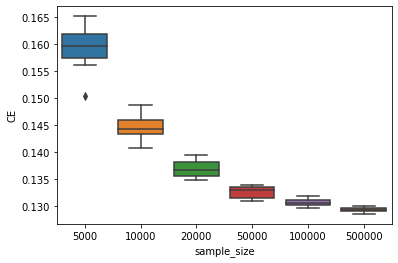

In [21]:
num_bins = 32

binners = Binner(n_bins=num_bins)
binner.fit(preds)


# Precompute multiple repeats of datasets of various sizes
sample_sizes = [5000, 10000, 20000, 50000, 100000, 500000]
prediction_repeats = {}
label_repeats = {}
num_repeats = 20
for n in sample_sizes:
    prediction_repeats[n] = []
    label_repeats[n] = []
    for r in range(num_repeats):
        X, y = cdg.get_sample(n)
        prediction_repeats[n].append(f.predict_proba(X)[:, 1])
        label_repeats[n].append(y)

repeats = [i for i in range(num_repeats)]
df = pd.DataFrame(
    list(product(sample_sizes, repeats)), columns=["sample_size", "repeat"]
)
df["CE"] = df.apply(
    lambda row: get_calibration_error_estimate(
        binner=binner,
        predictions=prediction_repeats[row["sample_size"]][row["repeat"]],
        labels=label_repeats[row["sample_size"]][row["repeat"]],
    ),
    axis=1,
)
sns.boxplot(data=df, x="sample_size", y="CE")


#### Problem 8: With reference to the plot of CE vs sample_size, describe the relationship between bias, variance, and sample size of the plug-in CE estimator as an estimator of f_bin (in this case, the binned version of f with 32 bins).  

Below we show the same plot but including two additional "de-biased" estimators of CE. You can see the difference is striking, even when n=20000 (which is an average of 625 points per bin).

<AxesSubplot:xlabel='sample_size', ylabel='CE'>

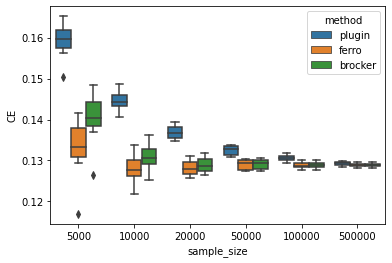

In [22]:
repeats = [i for i in range(num_repeats)]
methods = ["plugin", "ferro", "brocker"]
df = pd.DataFrame(
    list(product(sample_sizes, repeats, methods)),
    columns=["sample_size", "repeat", "method"],
)
df["CE"] = df.apply(
    lambda row: get_calibration_error_estimate(
        binner=binner,
        predictions=prediction_repeats[row["sample_size"]][row["repeat"]],
        labels=label_repeats[row["sample_size"]][row["repeat"]],
        method=row["method"],
    ),
    axis=1,
)
sns.boxplot(data=df, x="sample_size", y="CE", hue="method")


Let's repeat our reproduction of the figure from Kumar, but this time with varying sample sizes.  For simplicity (and since we're focused here on bias), we don't do any repeats.

<AxesSubplot:xlabel='num_bins', ylabel='CE'>

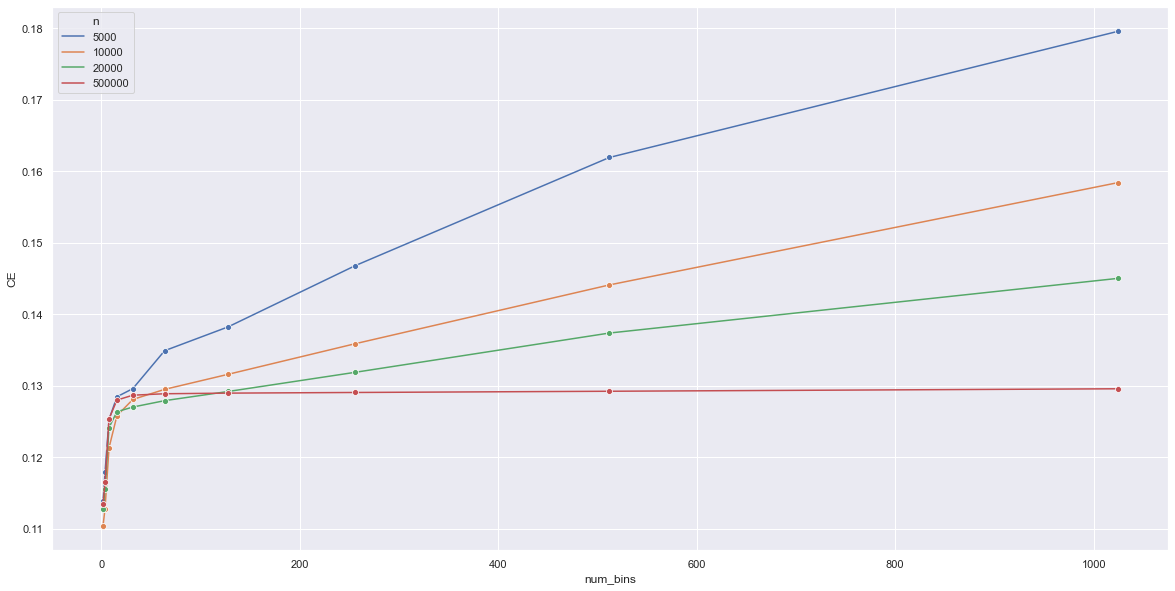

In [23]:
# Increase the number of bins and visualize the validation error, repeat for multiple test set sizes
sample_sizes = [5000, 10000, 20000, 500000]
num_bins = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

binners = {}
## Precompute binners on separate data
X, _ = cdg.get_sample(100000)
preds = f.predict_proba(X)[:, 1]
for b in num_bins:
    binner = Binner(n_bins=b)
    binner.fit(preds)
    binners[b] = binner

# Precompute datasets of various sizes
predictions = {}
labels = {}
for n in sample_sizes:
    X, y = cdg.get_sample(n)
    predictions[n] = f.predict_proba(X)[:, 1]
    labels[n] = y

df = pd.DataFrame(
    list(product(num_bins, sample_sizes)), columns=["num_bins", "sample_size"]
)
df["CE"] = df.apply(
    lambda row: get_calibration_error_estimate(
        binner=binners[row["num_bins"]],
        predictions=predictions[row["sample_size"]],
        labels=labels[row["sample_size"]],
    ),
    axis=1,
)
#sns.set(rc={"figure.figsize": (20, 10)})
df["n"] = df["sample_size"].astype(str)
sns.lineplot(data=df, x="num_bins", y="CE", hue="n", marker="o")

#### Problem 9: For each sample size, there is a general trend of increasing estimated CE as we increase the number of bins. In light of this result and the other problems, how do you explain this trend?  Are different factors at play for different combinations of sample size and num_bin?